In [33]:
# SGDClassifier but with less features. 
# Same performance as the previous iteration, however

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import joblib

In [34]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

survival 	Survival 	0 = No, 1 = Yes

pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd

sex 	Sex 	

Age 	Age in years 	

sibsp 	# of siblings / spouses aboard the Titanic 	

parch 	# of parents / children aboard the Titanic 	

ticket 	Ticket number 	

fare 	Passenger fare 	

cabin 	Cabin number 	

embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [35]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [36]:
# only 2 values are null, so it's not worth using an imputer
train_set.dropna(subset=["Embarked"], inplace=True)
nec_data = train_set.copy()

# making y_train
nec_data = nec_data.drop("Survived", axis=1)
survived = pd.DataFrame(train_set["Survived"].copy())

# Anything individual, not categorial, is irrelevant
nec_data = nec_data.drop("Name", axis=1)
nec_data = nec_data.drop("PassengerId", axis=1)
nec_data = nec_data.drop("Ticket", axis=1)
# too many null values
nec_data = nec_data.drop("Cabin", axis=1)
# no real relations to be found in either of these imo
nec_data = nec_data.drop("SibSp", axis=1)
nec_data = nec_data.drop("Parch", axis=1)

nec_data["class_fare"] = nec_data["Pclass"] * nec_data["Fare"]
nec_data = nec_data.drop("Pclass", axis=1)
nec_data = nec_data.drop("Fare", axis=1)

In [37]:
nec_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sex         889 non-null    object 
 1   Age         712 non-null    float64
 2   Embarked    889 non-null    object 
 3   class_fare  889 non-null    float64
dtypes: float64(2), object(2)
memory usage: 34.7+ KB


[]

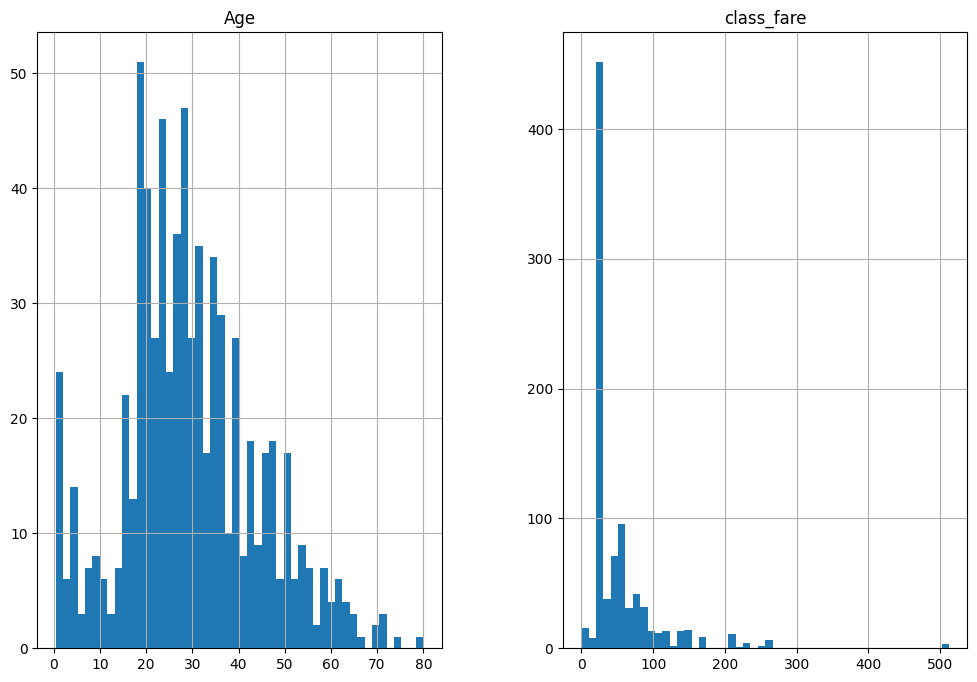

In [38]:
nec_num = nec_data.select_dtypes(include=[np.number])
nec_num.hist(bins=50, figsize=(12, 8))
plt.plot()

In [39]:
def safe_log(x):
    return np.log(x + 1e-10)
#thanks to ChatGPT 3.5 for this function

log_transformer = FunctionTransformer(func=safe_log, inverse_func=np.exp)
num_tail_pipeline = make_pipeline(SimpleImputer(strategy="median"), log_transformer, StandardScaler())
text_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
preprocess = ColumnTransformer([
    ("tail", num_tail_pipeline, ["class_fare"]),
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)

In [40]:
sgd_clf = Pipeline([("pre", preprocess), ("clf", SGDClassifier(loss='hinge', learning_rate="optimal", random_state=446))])
survived = np.array(survived).ravel()
sgd_clf.fit(nec_data, survived)
print(sgd_clf.predict(nec_data[:10]))
print(survived[:10])

[0 1 1 1 0 0 0 0 1 1]
[0 1 1 1 0 0 0 0 1 1]


In [41]:
randarr = np.zeros(10)
for k in range(len(randarr)):
    randarr[k] = random.uniform(0.13, 0.15)
print(randarr)
param_distribs = {"clf__alpha": randarr}
rmd_search = RandomizedSearchCV(
    sgd_clf, param_distributions=param_distribs, n_iter=10, cv=3, scoring="neg_root_mean_squared_error", random_state=446
)

rmd_search.fit(nec_data, survived)

[0.14423181 0.14328261 0.1493558  0.13358652 0.13685533 0.14970231
 0.13140224 0.14852033 0.14854847 0.13573827]


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('tail',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(func=<function safe_log at 0x00...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A02FC2BEE0>)])),
                                             ('clf',
                                              SGDClassifier(random_state=331))]),
                   param_distributions={'clf__alpha': array([0.14423181, 0.14328261, 0.1493558 , 0.13358652, 0.13685533,
       0.14970231, 0.13140224, 0.14852033, 0.14854847, 0.13573827])},
                   random_state=331, scoring='neg_root_mean_squared_error')

In [42]:
final_model = rmd_search.best_estimator_
print(final_model.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('tail',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function safe_log at 0x000001A02D6CFAC0>,
                                                                                       inverse_func=<ufun...
                      

In [43]:
rmse = -cross_val_score(final_model, nec_data, survived, scoring="neg_root_mean_squared_error", cv=10)
print(rmse)

[0.43704832 0.44971901 0.48575205 0.39661489 0.44971901 0.47404546
 0.48575205 0.50835712 0.43704832 0.48850421]


In [44]:
# ids2 = np.array(test_set["PassengerId"].copy()).ravel()
# test_set["class_fare"] = test_set["Pclass"] * test_set["Fare"]
# test_pred = final_model.predict(test_set)
# with open('sacreddeer_titanic_submission_2.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["PassengerId", "Survived"])
#     for k in range(len(ids2)):
#         writer.writerow([ids2[k], test_pred[k]])